In [30]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Dengue prediction model

In this notebook I develop a machine learning model to predict dengue cases reported each week in San Juan, Puerto Rico and Iquitos, Peru. 

Dengue is a viral disease caused by the dengue virus, which is transmitted to humans by the bite of infected mosquitoes.

As per the challenge link, data has been collected by "_various U.S. Federal Government agencies—from the Centers for Disease Control and Prevention to the National Oceanic and Atmospheric Administration in the U.S. Department of Commerce_"

# The approach

Yes, this a Kaggle-style challenge. However we do not solve Kaggle challenges daily, but rathers develop data products with a real-life impact.

Challenge is to predict dengue cases for the current week, given a set of variables. This is of limited use in real life. Ideally we would like to know dengue cases well in advance, to plan accordingly—this in turns depends on who is the customer. However we can safely say that what is really useful is a way of predicting dengue cases over a period of no less than 2/3 months

- Idea: Develop a model to predict dengue
- Usage: Actions taken as a result of having predictions, Crystal ball test. In this case: hospital, adjust capacity, scheduling, recruiting: **Predictions must be further into the future, no use having predictions for current week** 
- Metrics: Baseline (baseline model provided). In this case MAE, but no business metrics
- Model: See below
- Interpretation: See below

# Importing the libraries

In [31]:
import pandas as pd
import klib
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({"font.size": 20})

# Reading the datasets

The datasets can be found at this https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread/data/

I have saved the data locally on my machine for convenience

In [32]:
X_train = pd.read_csv("../../data/training_features.csv")
y_train = pd.read_csv("../../data/training_labels.csv")

X_test = pd.read_csv("../../data/test_features.csv")
y_test = X_test[["city", "year", "weekofyear"]].copy()
y_test["total_cases"] = None

# For simplicity, we create a single dataset
X = pd.concat((X_train, X_test)).reset_index(drop=True)
Y = pd.concat((y_train, y_test)).reset_index(drop=True)
df = X.merge(Y)

# Sort values for convenience
df = df.sort_values(by=["city", "week_start_date"]).reset_index(drop=True)

# Create a label train/test for convenience
df["train"] = 1
df.loc[df["total_cases"].isna(), "train"] = 0

# Preliminary checks on data quality

Each row represents a week of environmental data (weather + vegetation) for two cities. The reported number of dengue cases is also there

In [33]:
df.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases,train
0,iq,2000,26,2000-07-01,0.192886,0.132257,0.340886,0.247200,25.41,296.740000,...,25.41,16.651429,8.928571,26.400000,10.775000,32.5,20.7,3.0,0,1
1,iq,2000,27,2000-07-08,0.216833,0.276100,0.289457,0.241657,60.61,296.634286,...,60.61,16.862857,10.314286,26.900000,11.566667,34.0,20.8,55.6,0,1
2,iq,2000,28,2000-07-15,0.176757,0.173129,0.204114,0.128014,55.52,296.415714,...,55.52,17.120000,7.385714,26.800000,11.466667,33.0,20.7,38.1,0,1
3,iq,2000,29,2000-07-22,0.227729,0.145429,0.254200,0.200314,5.60,295.357143,...,5.60,14.431429,9.114286,25.766667,10.533333,31.5,14.7,30.0,0,1
4,iq,2000,30,2000-07-29,0.328643,0.322129,0.254371,0.361043,62.76,296.432857,...,62.76,15.444286,9.500000,26.600000,11.480000,33.3,19.1,4.0,0,1


Check that time index is ok

In [34]:
from dengue_prediction.preprocessing.cleaning import get_time_diff_col

In [35]:
df = get_time_diff_col(df)

In [36]:
df["time_difference"].value_counts()

7 days    1834
8 days      26
9 days      10
Name: time_difference, dtype: int64

In [37]:
df[df["time_difference"].dt.days != 7] # Always start week from new year

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases,train,time_difference
0,iq,2000,26,2000-07-01,0.192886,0.132257,0.340886,0.247200,25.41,296.740000,...,16.651429,8.928571,26.400000,10.775000,32.5,20.7,3.0,0,1,NaT
26,iq,2001,1,2001-01-01,0.254714,0.228529,0.250586,0.287000,59.11,297.958571,...,18.672857,6.942857,27.333333,11.000000,33.3,21.8,38.9,0,1,9 days
78,iq,2002,1,2002-01-01,0.405729,0.348400,0.368643,0.380014,70.16,297.132857,...,17.618571,5.942857,27.950000,9.450000,33.2,23.0,45.3,4,1,8 days
130,iq,2003,1,2003-01-01,0.323414,0.300414,0.329186,0.318429,46.91,299.375714,...,17.452857,12.100000,28.450000,9.950000,34.4,22.4,92.9,10,1,8 days
182,iq,2004,1,2004-01-01,0.202571,0.198967,0.244557,0.187957,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,1,8 days
234,iq,2005,53,2005-01-01,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,1,9 days
286,iq,2006,52,2006-01-01,0.354600,0.219950,0.322517,0.256333,114.58,298.181429,...,18.584286,7.385714,27.450000,9.700000,32.7,22.4,273.5,8,1,8 days
338,iq,2007,1,2007-01-01,0.220117,0.158957,0.190571,0.132400,79.94,297.288571,...,18.144286,7.414286,26.600000,7.950000,31.9,21.5,133.4,0,1,8 days
390,iq,2008,1,2008-01-01,0.191471,0.155414,0.176014,0.187243,19.95,299.277143,...,16.260000,10.728571,28.275000,11.575000,36.0,21.5,NaN,29,1,8 days
442,iq,2009,1,2009-01-01,0.151286,0.161686,0.153271,0.119443,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,9 days


In [38]:
df.drop("time_difference", axis=1, inplace=True)

According to the problem description here, we have 4 categories of features https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread/page/82/

I mixed things up a bit, but still divided the features into 4 groups

In [39]:
# Small hack 
df.rename(columns={"reanalysis_tdtr_k": "reanalysis_temp_rng_k" }, inplace=True)

end =  "\n\n" + "*"*150 +  "\n "

print(end)

precipitation = list(df.filter(regex="precip").columns)
print("Precipitation columns:", precipitation,  end)


temperature = list(df.filter(regex="temp").columns)
print(f"Temperature columns:", temperature, end)


humidity = list(df.filter(regex="humidity").columns)
print(f"Humidity columns:", humidity, end)


vegetation = list(df.filter(regex="ndvi").columns)
print("Satellite vegetation columns:", vegetation, end)



******************************************************************************************************************************************************
 
Precipitation columns: ['precipitation_amt_mm', 'reanalysis_precip_amt_kg_per_m2', 'reanalysis_sat_precip_amt_mm', 'station_precip_mm'] 

******************************************************************************************************************************************************
 
Temperature columns: ['reanalysis_air_temp_k', 'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k', 'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k', 'reanalysis_temp_rng_k', 'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c', 'station_min_temp_c'] 

******************************************************************************************************************************************************
 
Humidity columns: ['reanalysis_relative_humidity_percent', 'reanalysis_specific_humidity_g_per_kg'] 

******************

Things to be noticed:

- There are 2 sets of weather columns: NOAA (The National Oceanic and Atmospheric Administration) GHCN (Global Historical Climatology Network) and reanalysis NCEP (National Centers for Environmental Prediction). Here it looks like that reanalysis is a kind of interpolation of past data using predictive weather models https://www.ecmwf.int/en/about/media-centre/focus/2020/fact-sheet-reanalysis If that's the case though, it is not clear why I have nulls

- There are features which look very similar and will be definitely highly correlated. For some of them it is also not clear what's the difference, e.g. 'reanalysis_air_temp_k', 'reanalysis_avg_temp_k'

In [40]:
df[df.filter(regex="reanalysis").isna().any(axis=1)].filter(regex="reanalysis")

,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_temp_rng_k
182,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
494,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
763,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
769,297.798571,298.057143,294.650000,300.2,295.3,20.1,82.875714,NaN,16.060000,2.200000
770,297.898571,298.107143,293.628571,300.1,296.3,4.4,77.295714,NaN,15.012857,2.585714
771,297.472857,297.678571,292.967143,299.3,296.3,14.4,76.037143,NaN,14.381429,2.414286
815,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1075,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
# Check no repeating columns
all_columns = temperature + precipitation + humidity + vegetation
len(all_columns) == len(set(all_columns))

True

In [42]:
# Check that we have included all columns, but city and time related ones
set(df.columns).difference(set(all_columns))

{'city', 'total_cases', 'train', 'week_start_date', 'weekofyear', 'year'}

# Data cleaning

## Nulls

What we can see from the plot below:
- No column has a lot of null values
- There are about 10 rows with a lot of nulls values
- The remaining rows have null values clustered in a feature group: might be worth imputing them leveraging their high degree of correlation
- The are only few sizable blocks of null data. As we are dealing time series, it can be sensible to just interpolate linearly the series

N.B: in the cleaning steps below I am putting together train and test data. In general one should determine data cleaning logics on the train data, and use the fitted parameters to process the test data. To speed things up here I will overlook this aspect

In [43]:
# For convenience 

df.insert(0, "_city", None)
df.loc[df["city"] == "sj", "_city"] = 1

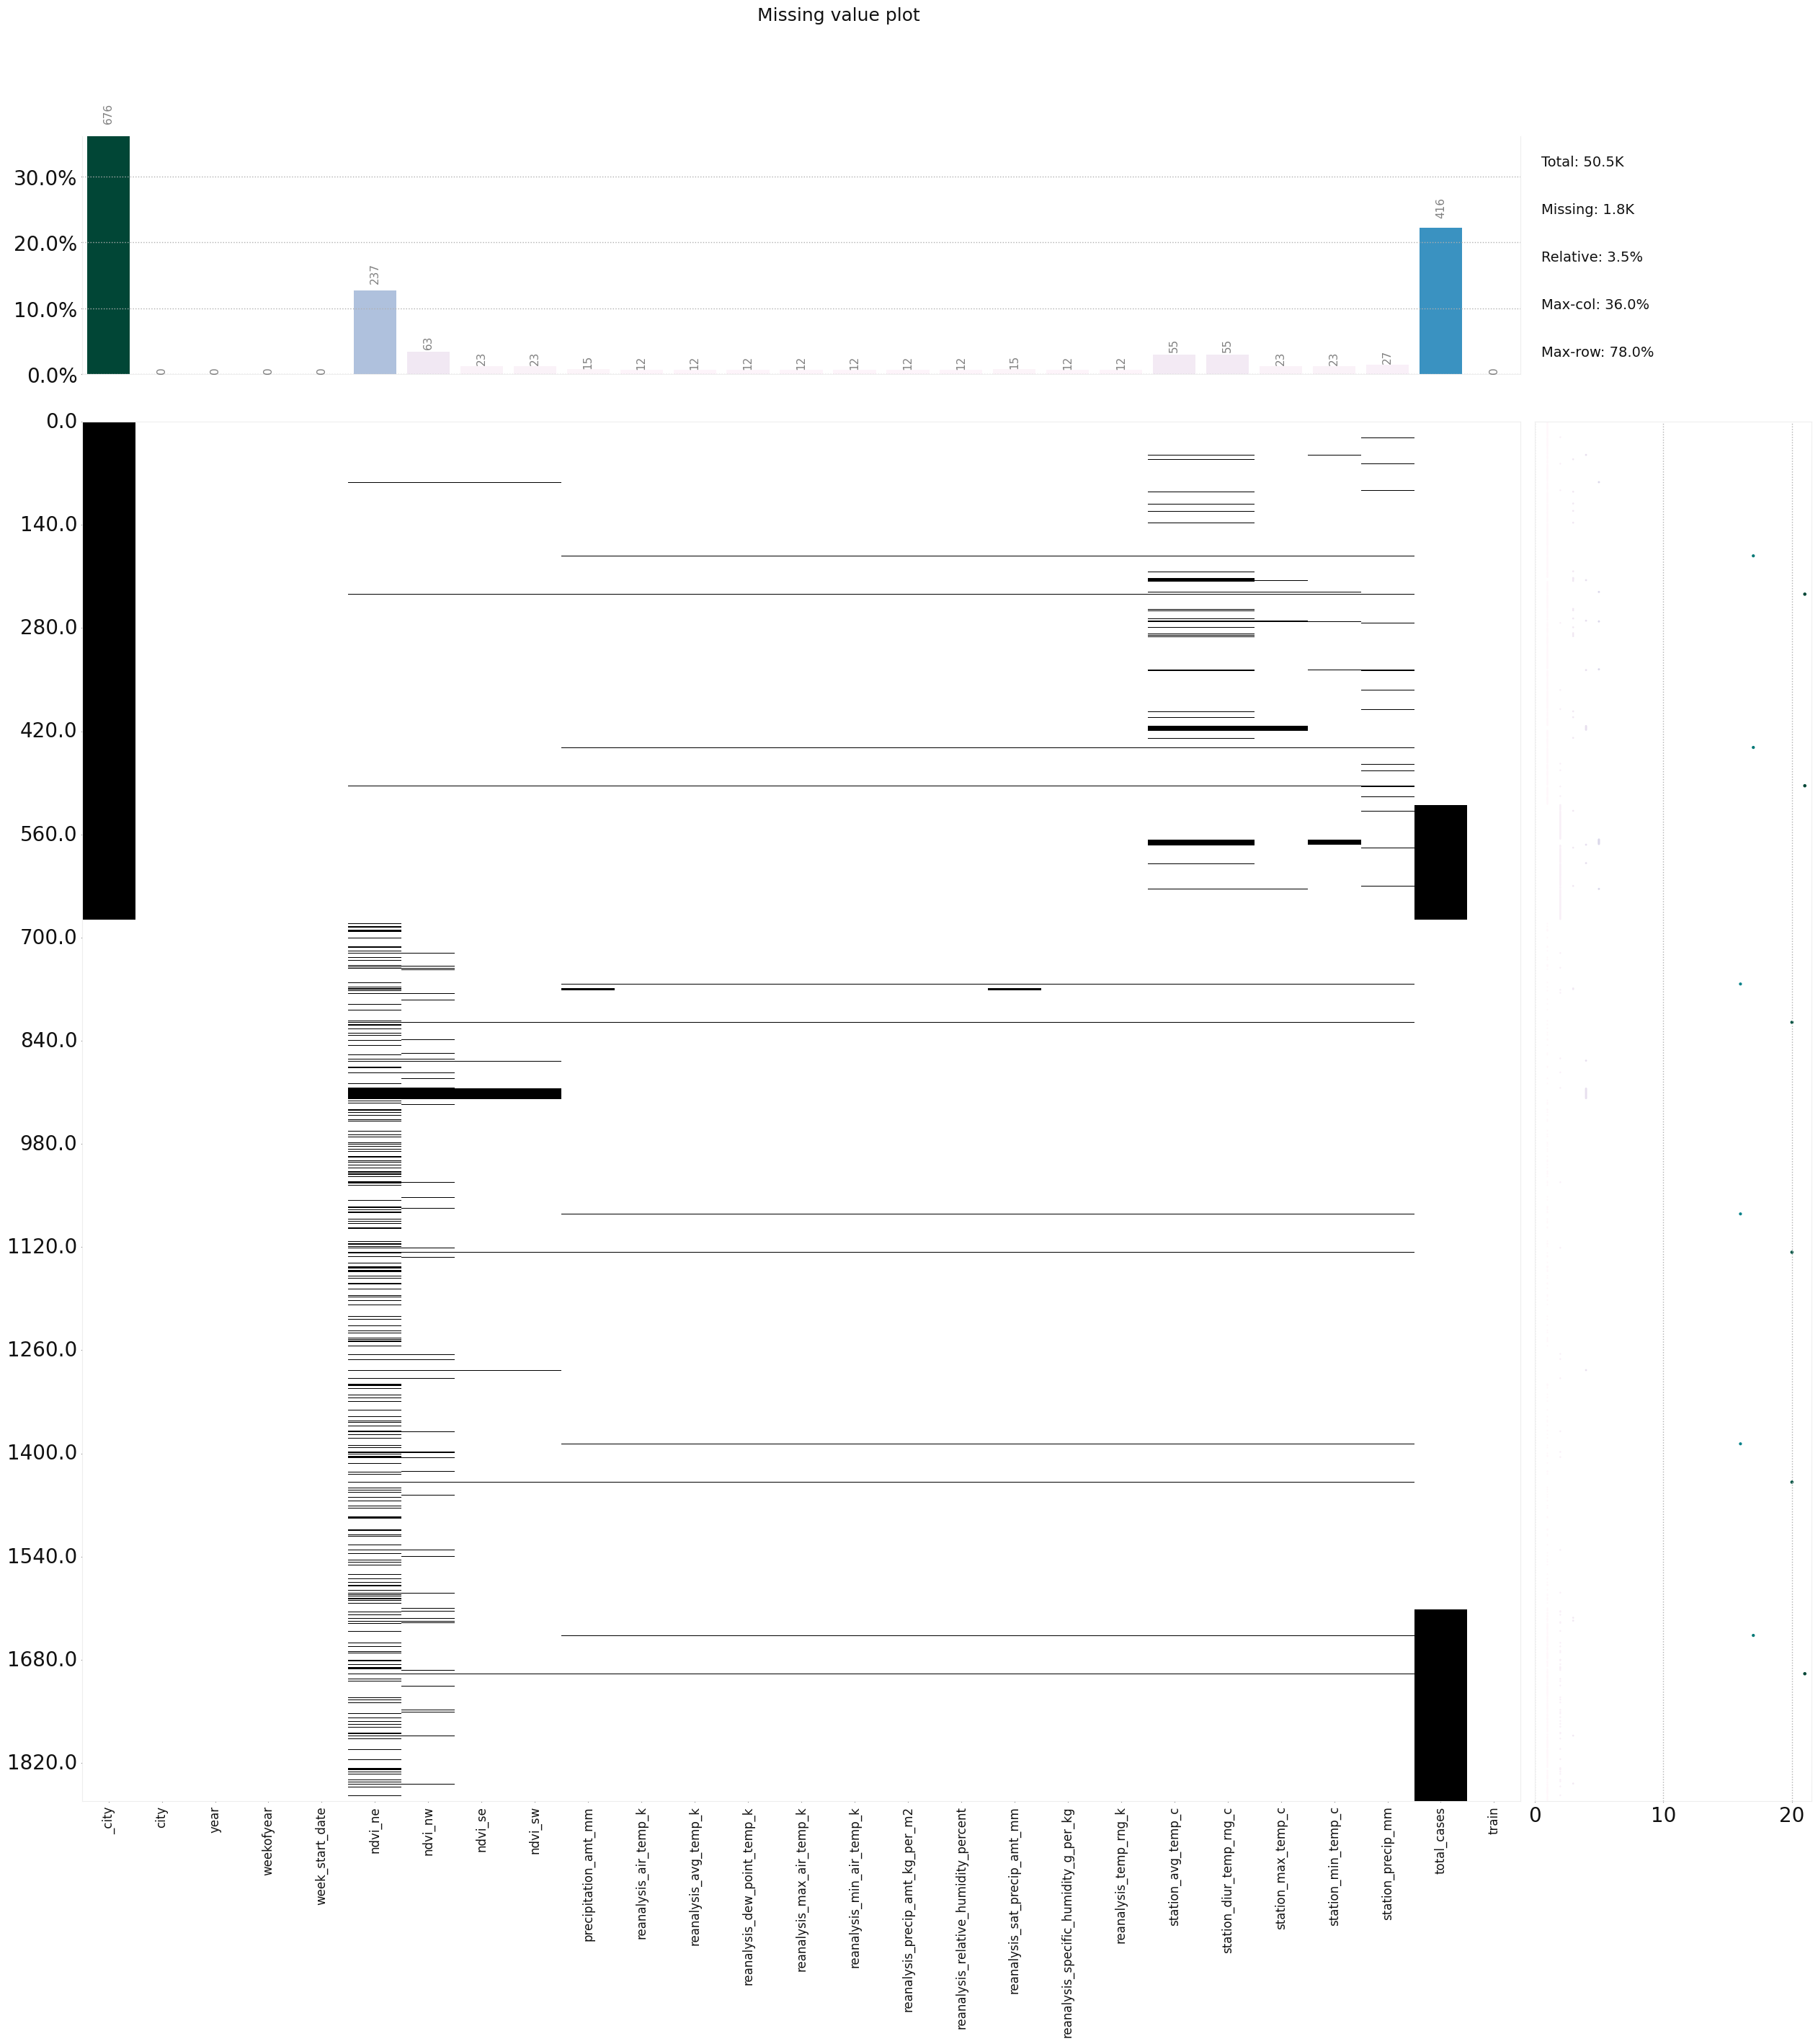

In [44]:
# Missing values 
klib.missingval_plot(df, figsize=(30, 30))
plt.show()

In [45]:
df.drop(columns="_city", inplace=True)

In [46]:
# Drop cases with more than 15 nulls
df.dropna(thresh=df.shape[1] - 15, inplace=True)

## Vegetation columns

Vegetation is the one with the highest number of null values

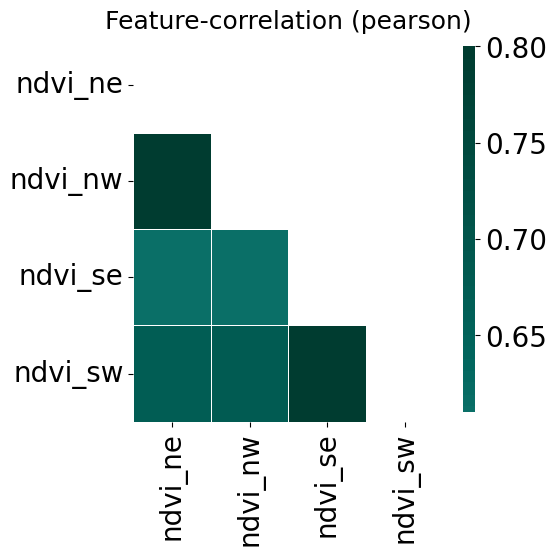

In [47]:
klib.corr_plot(df[vegetation], annot=False, figsize=(5, 5))
plt.show()

In [48]:
from dengue_prediction.preprocessing.cleaning import fill_nulls

In [49]:
df[vegetation].isna().sum()

ndvi_ne    231
ndvi_nw     57
ndvi_se     17
ndvi_sw     17
dtype: int64

In [50]:
df = fill_nulls(df, vegetation)

Nulls are reduced to those lines with all ndvi null fields 

In [51]:
df[vegetation].isna().sum()

ndvi_ne    17
ndvi_nw    17
ndvi_se    17
ndvi_sw    17
dtype: int64

In [52]:
df[df[vegetation].isna().all(axis=1)]

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_temp_rng_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases,train
82,iq,2002,5,2002-01-29,NaN,NaN,NaN,NaN,59.40,296.858571,...,59.40,17.690000,5.228571,26.300000,9.700000,32.5,20.8,120.2,12,1
867,sj,1994,52,1994-01-01,NaN,NaN,NaN,NaN,5.25,298.527143,...,5.25,15.780000,2.442857,26.971429,8.200000,32.8,21.7,0.3,22,1
905,sj,1994,38,1994-09-24,NaN,NaN,NaN,NaN,39.22,299.885714,...,39.22,17.354286,1.985714,28.371429,6.185714,32.2,24.4,34.3,302,1
906,sj,1994,39,1994-10-01,NaN,NaN,NaN,NaN,55.88,299.508571,...,55.88,17.248571,2.600000,28.014286,6.700000,33.9,23.3,31.5,395,1
907,sj,1994,40,1994-10-08,NaN,NaN,NaN,NaN,0.63,300.377143,...,0.63,16.744286,2.628571,28.714286,6.900000,34.4,24.4,8.2,426,1
908,sj,1994,41,1994-10-15,NaN,NaN,NaN,NaN,16.70,299.638571,...,16.70,16.900000,2.728571,28.328571,7.657143,35.0,23.9,39.2,461,1
909,sj,1994,42,1994-10-22,NaN,NaN,NaN,NaN,75.57,300.238571,...,75.57,17.124286,3.028571,28.571429,7.442857,35.0,23.9,5.4,381,1
910,sj,1994,43,1994-10-29,NaN,NaN,NaN,NaN,111.52,298.811429,...,111.52,17.641429,1.657143,27.671429,7.271429,32.8,23.3,39.2,333,1
911,sj,1994,44,1994-11-05,NaN,NaN,NaN,NaN,5.41,299.867143,...,5.41,17.264286,2.328571,28.157143,6.842857,32.2,24.4,1.9,353,1
912,sj,1994,45,1994-11-12,NaN,NaN,NaN,NaN,32.26,299.297143,...,32.26,16.984286,2.228571,27.314286,6.928571,31.7,22.2,54.5,410,1


## Temperature columns

In [53]:
df[df[temperature].isna().any(axis=1)]

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_temp_rng_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases,train
45,iq,2001,20,2001-05-14,0.315343,0.319650,0.262700,0.303486,74.08,297.297143,...,74.08,18.640000,5.642857,NaN,NaN,32.5,NaN,0.0,0,1
51,iq,2001,26,2001-06-25,0.192300,0.275286,0.316457,0.325414,1.22,294.845714,...,1.22,12.464286,12.342857,NaN,NaN,32.3,17.1,31.0,0,1
95,iq,2002,18,2002-04-30,0.170357,0.141829,0.197729,0.257071,60.05,297.408571,...,60.05,17.807143,7.500000,NaN,NaN,33.5,21.2,1.0,9,1
111,iq,2002,34,2002-08-20,0.345425,0.313540,0.295050,0.309267,31.71,296.184286,...,31.71,14.045714,12.757143,NaN,NaN,33.1,20.8,70.6,4,1
121,iq,2002,44,2002-10-29,0.329086,0.286214,0.294057,0.315929,89.77,298.518571,...,89.77,18.602857,9.028571,NaN,NaN,34.1,22.5,34.1,28,1
137,iq,2003,8,2003-02-19,0.126257,0.135514,0.103657,0.133714,25.03,298.567143,...,25.03,18.020000,10.885714,NaN,NaN,32.4,23.3,121.9,3,1
203,iq,2004,22,2004-05-27,0.190314,0.077843,0.193171,0.102329,35.43,297.305714,...,35.43,17.500000,9.628571,NaN,NaN,33.3,20.5,28.2,5,1
212,iq,2004,31,2004-07-29,0.208900,0.155500,0.220300,0.254257,85.96,296.017143,...,85.96,15.975714,8.842857,NaN,NaN,32.9,19.4,6.0,6,1
213,iq,2004,32,2004-08-05,0.248900,0.265957,0.218529,0.237557,29.82,297.517143,...,29.82,14.694286,12.157143,NaN,NaN,34.0,18.3,55.1,5,1
214,iq,2004,33,2004-08-12,0.191071,0.227000,0.168529,0.295700,18.44,296.530000,...,18.44,13.824286,12.185714,NaN,NaN,31.3,20.0,0.5,6,1


Her we use some common sense-driven assumption and we do some inputing by hand

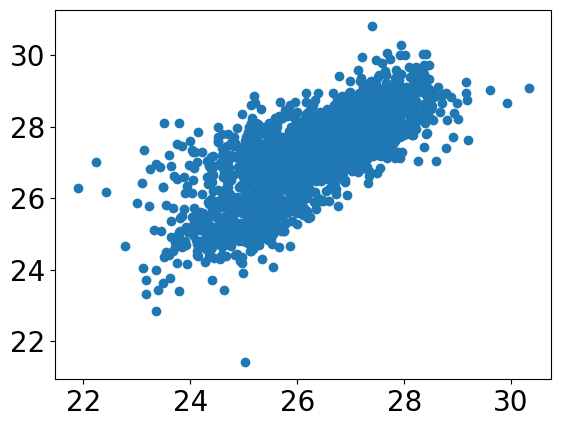

In [54]:
# Very correlated 
plt.scatter(df["reanalysis_avg_temp_k"] - 273, df["station_avg_temp_c"])

In [55]:
df["station_max_temp_c"].fillna(df["reanalysis_max_air_temp_k"] - 273, inplace=True)
df["station_min_temp_c"].fillna(df["reanalysis_min_air_temp_k"] - 273, inplace=True)

In [56]:
df["station_avg_temp_c"].fillna(0.5*(df["station_max_temp_c"] + df["station_min_temp_c"]), inplace=True)
df["station_diur_temp_rng_c"].fillna(df["station_max_temp_c"] - df["station_min_temp_c"], inplace=True)

In [57]:
df[df[temperature].isna().any(axis=1)]

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_temp_rng_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases,train


## Precipitation columns

In [58]:
df[precipitation].isna().sum()

precipitation_amt_mm                3
reanalysis_precip_amt_kg_per_m2     0
reanalysis_sat_precip_amt_mm        3
station_precip_mm                  15
dtype: int64

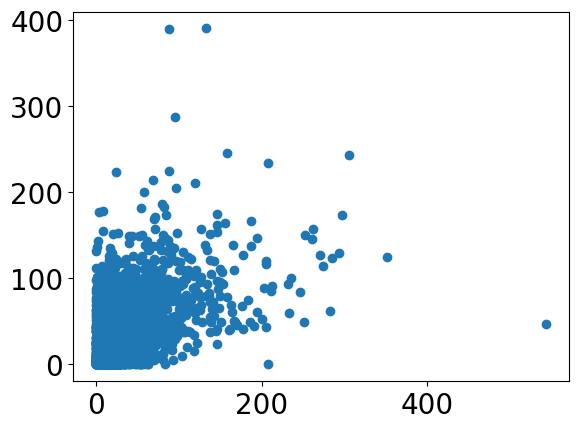

In [59]:
# Surprisingly these are not very correlated
plt.scatter(df["station_precip_mm"], df["precipitation_amt_mm"])

In [ ]:
klib.corr_plot(df[precipitation], annot=False, figsize=(5, 5))
plt.show()

In [ ]:
df["station_precip_mm"].fillna(df["precipitation_amt_mm"], inplace=True)

In [ ]:
df[df[precipitation].isna().any(axis=1)]

To fill the remaining nulls, we note that there are only a few windows of missing data

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
df[vegetation].isna().cumsum().plot(ax=ax[0])
(df[vegetation].isna().cumsum() - df[vegetation].isna().cumsum().shift(1)).plot(ax=ax[1])
plt.show()

We linearly interpolate data where that is missing under a ceratin threshold. ALternatives:
- Regress on week number (however we are talkign about equatorial place, so no much seasonality)
- Knn 
- Don't want to spend much time

In [ ]:
from dengue_prediction.preprocessing.cleaning import interpolate, find_null_window_size

In [ ]:
df.isna().sum()

In [ ]:
for col in df.columns[4:-2]:
    df = df.groupby("city", group_keys=False).apply(lambda x: interpolate(x, col))

In [ ]:
df.isna().sum()

In [ ]:
# Approximation: fill with average + noise

In [ ]:
df.loc[:, vegetation] = df[vegetation].fillna(df[vegetation].mean() + 0.01*np.random.randn())

In [ ]:
klib.dist_plot(df.iloc[:, 4:], size=4, 
               rug_kws={"alpha": 0.5, "linewidth": 2, "height": 0.1})

# Data correlation

In [ ]:
from dengue_prediction.preprocessing.correlation import define_correlated_variable_groups

In [ ]:
# Hierarchical clustering to understand correlated variable groups

In [ ]:
cols = df.columns[4:-2]
correlated_groups = define_correlated_variable_groups(df[cols], correlation_threshold=0.9)
correlated_groups

In [ ]:
for k, v in correlated_groups.items():
    df.drop(v[1:], axis=1, inplace=True)  

# Preprocessing

In [ ]:
from sklearn.preprocessing import RobustScaler

In [ ]:
df.drop(["year", "week_start_date"],  axis=1, inplace=True)

In [ ]:
# City 
df["city"] = (df["city"] == "iq").astype(int)

In [ ]:
cols = df.columns[1:-1]

In [ ]:
rs = RobustScaler()
df[cols] = rs.fit_transform(df[cols])

# Our starting point: the baseline model

A baseline model has been provided here: https://github.com/drivendata/benchmarks/blob/master/dengue-benchmark-statsmodels.ipynb

Relevant observations:
- This is a count prediction problem. Makes sense trying Poisson regression or Negative Binomial Regression. By inspection, labels mean != labels variance, therefore better try the latter
- Pearson correlation shows no strong correlations. Sign of correlation seems to have sense
- Fitted model shows weaknesses

To do:
- Null values
- Learning curve
- SIR model

In [ ]:
from dengue_prediction.preprocessing.sklearn_wrapper_statsmodel import SMFormulaWrapper
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [ ]:
df.dropna(inplace=True)

In [ ]:
X = df.iloc[:, :-1].copy()
y = df["total_cases"].copy()

In [ ]:
baseline_model_formula = "total_cases ~ 1 + " \
                "reanalysis_dew_point_temp_k + " \
                "station_min_temp_c + " \
                "station_avg_temp_c"

model = SMFormulaWrapper(model_class=smf.glm, family=sm.families.NegativeBinomial(), formula=baseline_model_formula)

In [ ]:
from dengue_prediction.utils.plot_learning_curve import plot_learning_curve

In [ ]:
plot_learning_curve(estimator=model, X=X, y=y, scoring="neg_mean_absolute_error")

### Modified baseline model (full formula)

In [ ]:
model_formula = "total_cases ~ 1 + " + " + ".join(list(df.columns[:-1]))

model = SMFormulaWrapper(model_class=smf.glm, family=sm.families.NegativeBinomial(), formula=model_formula)

In [ ]:
plot_learning_curve(estimator=model, X=X, y=y, scoring="neg_mean_absolute_error")

In [ ]:
model = SMFormulaWrapper(model_class=smf.glm, family=sm.families.NegativeBinomial(), formula=model_formula)

In [ ]:
model.fit(X, y)

In [ ]:
Y = y.to_frame()
Y["city"] = X["city"]
Y["total_cases_pred"] = model.predict(X)

In [ ]:
for c in range(2):   
    fig, ax = plt.subplots(figsize=(30, 10))
    Y[Y["city"] == c]["total_cases"].plot()
    Y[Y["city"] == c]["total_cases_pred"].plot()
    plt.show()

In [ ]:
from dengue_prediction.training.utils import lag_training_scores

scores = lag_training_scores(base_model=SMFormulaWrapper(model_class=smf.glm, family=sm.families.NegativeBinomial(), formula=model_formula), X=X, y=y, N=500)

pd.DataFrame.from_dict(scores, orient="index").plot()
plt.ylabel("negative mean absolute error")
plt.xlabel("Lags")
plt.show()

# Time series properties 

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf

In [ ]:
plot_acf(Y[Y["city"] == 0]["total_cases"], lags=500)
plot_acf(Y[Y["city"] == 1]["total_cases"], lags=500)
plt.show()



In [ ]:
from scipy.signal import argrelextrema

In [ ]:
argrelextrema(acf(Y[Y["city"] == 0]["total_cases"], nlags=500), np.greater)

In [ ]:
plot_acf(Y[Y["city"] == 0]["total_cases"], lags=200)

In [ ]:
plot_pacf(Y["total_cases"], method="ywm", lags=500)
plt.show()

In [ ]:
plot_acf(Y["total_cases"].diff(periods=30).dropna(), lags=500)

In [ ]:
autocorrelation_plot(Y[Y.city == 0]["total_cases"][:500])
autocorrelation_plot(Y[Y.city == 1]["total_cases"][:500])

Dicky Fuller test to check stationarity does not make se

In [ ]:
from statsmodels.tsa.stattools import adfuller

In [ ]:
adfuller()

In [ ]:
Y.groupby("city")["total_cases"].apply(lambda x: adfuller(x, autolag='AIC', regression='ct', maxlag=100)).apply(lambda x: x[1])

In [ ]:
ad_fuller = {}
for c in X.columns[2:-1]:
    ad_fuller[c] = X.groupby("city")[c].apply(lambda x: adfuller(x, autolag='AIC', regression='ctt', maxlag=60)).apply(lambda x: x[1])

In [ ]:
pd.DataFrame(ad_fuller).T  > 0.05

Arima computationally very expensive

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

def predict_arima(train, n_predictions):
    
    predictions = []
    history = [x for x in train]
    
    for t in range(n_predictions):
        arima = ARIMA(history, order=(1,1,10))
        model_fit = arima.fit()
        output = model_fit.forecast()
        yhat = int(output[0])
        predictions.append(yhat)
        history.append(yhat)
       
    return predictions

In [ ]:
A = Y[Y.city == 0]["total_cases"].values
size = int(len(A) * 0.66)
train = A[0:size]
test = A[size:]

preds = predict_arima(A, len(test))

In [ ]:
plt.plot(preds)

We have all stationary features, and for this reason, plus the fact that we don't have a huge amount of data, we are going to create lag features rather than using NN models such as LSTM able to capture 

**Also to have a useful model, a model that predicts just for the next week is not that helpful (USAGE??) . We have to options:** 

1. Predict future features 
2. Predict multiple labels

# Create lagged features 

In [ ]:
from dengue_prediction.training.lags import create_training_sets

In [ ]:
_X, _y = create_training_sets(df, lag=60, pred_lag=1)

In [ ]:
_X.shape

In [ ]:
_X = _X.dropna()
_y = y.loc[_X.index]

In [ ]:
from sklearn.linear_model import Lasso

In [ ]:
lasso = Lasso()

In [ ]:
X.shape

In [ ]:
lasso.fit(_X, _y)

In [ ]:
C = pd.DataFrame({"features": _X.columns, "coef": lasso.coef_})

In [ ]:
C[C["coef"] != 0]

In [ ]:
features = list(C[C["coef"] != 0]["features"].unique())

In [ ]:
model_formula = "total_cases ~ 1 + " + " + ".join(features)

model = SMFormulaWrapper(model_class=smf.glm, family=sm.families.NegativeBinomial(alpha=0.001), formula=model_formula)

In [ ]:
plot_learning_curve(estimator=model, X=_X, y=_y, scoring="neg_mean_absolute_error")
plt.ylim(-30, 0)

In [ ]:
from dengue_prediction.training.lags import get_preds_lagged_model

In [ ]:
preds, y, lc, uc = get_preds_lagged_model(df, lag=30, pred_lag=1)

In [ ]:
plt.figure(figsize=(30, 10))
plt.plot(preds)
plt.plot(y)
plt.fill_between(range(len(lc)), lc, uc, alpha=0.5)


In [ ]:
mean_absolute_error(y, preds)

Without the total_cases features

In [ ]:
preds, y, lc, uc = get_preds_lagged_model(df, lag=30, pred_lag=1, lag_label=False)

In [ ]:
plt.figure(figsize=(30, 10))
plt.plot(preds)
plt.plot(y)
plt.fill_between(range(len(lc)), lc, uc, alpha=0.5)




In [ ]:
mean_absolute_error(y, preds)

Using predictions to feed the model

In [ ]:
preds, y, lc, uc = get_preds_lagged_model(df, lag=30, pred_lag=260, use_predictions=True)

In [ ]:
plt.figure(figsize=(30, 10))
plt.plot(preds)
plt.plot(y)
plt.fill_between(range(len(lc)), lc, uc, alpha=0.5)
print(mean_absolute_error(y, preds))

In [ ]:
X_train[X_train["city"] == "sj"]

In [ ]:
X_test[X_test["city"] == "sj"]

In [ ]:
from sklearn.metrics import mean_absolute_error

In [ ]:
mean_absolute_error(y, preds)

We are using 

In [ ]:
maes = []
for pl in range(1, 52):
    if pl % 10 == 0:
        print(pl, end="...")
    maes.append(get_metrics_lagged_model(df, lag=30, pred_lag=pl))

In [ ]:
plt.plot(maes)